In [36]:
import pandas as pd
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn

In [37]:
# imperting helper functions
from helper_functions import plot_predictions,plot_decision_boundary

In [38]:
# Make 1000 samples 
n_samples = 1000

In [39]:
# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [40]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [41]:
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [42]:
# Check different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

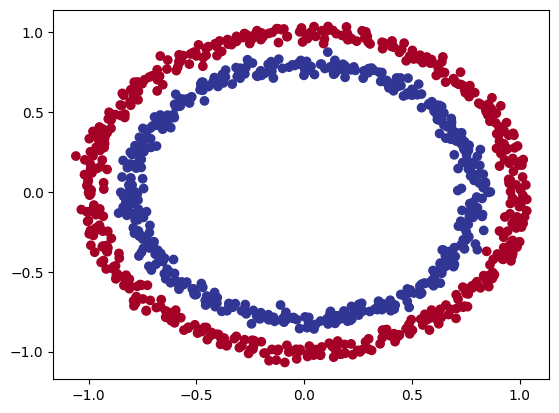

In [43]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [44]:
# Check the shapes of our features and labels
X.shape, y.shape

((1000, 2), (1000,))

In [45]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [46]:
# dividing the data into 80% - 20%
X_train , X_test , y_train , y_test =train_test_split(X,y,test_size=0.2,random_state=42)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [48]:
# constructing teh model
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1=nn.Linear(in_features=2,out_features=5)
        self.layer2=nn.Linear(in_features=5,out_features=1)
    
    def forward (self,x):
        return self.layer2(self.layer1(x))
    

In [49]:
model_0=CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [50]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")

Length of test samples: 200, Shape: torch.Size([200])

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])
Length of predictions: 200, Shape: torch.Size([200, 1])

First 10 predictions:
tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667],
        [-0.1484],
        [-0.0826],
        [-0.0946],
        [-0.1918],
        [-0.0944]], grad_fn=<SliceBackward0>)


In [51]:
# Logits are the outputs of a neural network before the activation function is applied

In [52]:
# BCELoss needs to receive the outputs of Sigmoid activation as its input, 
# but the other-one BCEWithLogitsLoss will need the logits as inputs instead 
# of outputs of Sigmoid, since it will apply sigmoid internally.

In [53]:
# creating loss and optimizer function
loss_fn= nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [54]:
# this fuc

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [55]:
# View the frist 5 outputs of the forward pass on the test data
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1269],
        [-0.0967],
        [-0.1908],
        [-0.1089],
        [-0.1667]], grad_fn=<SliceBackward0>)

In [56]:
# using the sigmoid activation function on the logit
y_pred_prob=torch.sigmoid (y_logits)
y_pred_prob

tensor([[0.4683],
        [0.4758],
        [0.4524],
        [0.4728],
        [0.4584]], grad_fn=<SigmoidBackward0>)

In [57]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_prob)
y_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [58]:
# sending first five values of the x test to the model and then perform sigmoid to it
y_pred_label=torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
y_pred_label

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [59]:
print(torch.eq(y_preds.squeeze(),y_pred_label.squeeze()))

tensor([True, True, True, True, True])


In [60]:
y_preds.squeeze()

tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)

In [61]:
torch.manual_seed(42)
epochs=100

In [62]:
X_train , y_train = X_train.to(device),y_train.to(device)
X_test , y_test = X_test.to(device),y_test.to(device)

In [63]:
# building train and test loop

for epoch in range(epochs):
    model_0.train()

    # 1.forward pass
    y_logits=model_0(X_train).squeeze()
    y_preds=torch.round(torch.sigmoid(y_logits))

    # 2.calculate loss/accuracy
    loss= loss_fn(y_logits,y_train)

    acc=accuracy_fn(y_true=y_train,y_pred=y_preds)

# 3. optimize the grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    # now we will test
    model_0.eval()
    with torch.inference_mode():
        # 1 forward pass
        test_logits=model_0(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        # 2. calculatee loss /accuracy
        test_loss=loss_fn(test_logits,y_test)
        test_acc=accuracy_fn(y_true=y_test,y_pred=test_pred)
    
    # now we will print the epoch ,loss ,accuracy ,test loss ,test accuracy
    # after every 10 epochs
    if epoch %10 == 0:
        print(f"Epoch: {epoch} || Loss: {loss} || Accuracy: {acc} || Test loss: {test_loss} || Test accuracy: {test_acc}")

Epoch: 0 || Loss: 0.6956855058670044 || Accuracy: 50.0 || Test loss: 0.6972116827964783 || Test accuracy: 50.0
Epoch: 10 || Loss: 0.6940255761146545 || Accuracy: 50.0 || Test loss: 0.696153998374939 || Test accuracy: 50.0


Epoch: 20 || Loss: 0.6934274435043335 || Accuracy: 46.0 || Test loss: 0.6958542466163635 || Test accuracy: 48.5
Epoch: 30 || Loss: 0.6932066082954407 || Accuracy: 49.0 || Test loss: 0.6957688331604004 || Test accuracy: 47.5
Epoch: 40 || Loss: 0.6931198835372925 || Accuracy: 49.5 || Test loss: 0.6957288384437561 || Test accuracy: 46.5
Epoch: 50 || Loss: 0.693081259727478 || Accuracy: 50.375 || Test loss: 0.6956887245178223 || Test accuracy: 46.5
Epoch: 60 || Loss: 0.6930606365203857 || Accuracy: 50.5 || Test loss: 0.6956409215927124 || Test accuracy: 46.5
Epoch: 70 || Loss: 0.693047285079956 || Accuracy: 50.5 || Test loss: 0.6955872178077698 || Test accuracy: 46.5
Epoch: 80 || Loss: 0.6930373311042786 || Accuracy: 50.74999999999999 || Test loss: 0.6955310702323914 || Test accuracy: 46.5
Epoch: 90 || Loss: 0.6930291652679443 || Accuracy: 50.375 || Test loss: 0.6954748630523682 || Test accuracy: 46.5


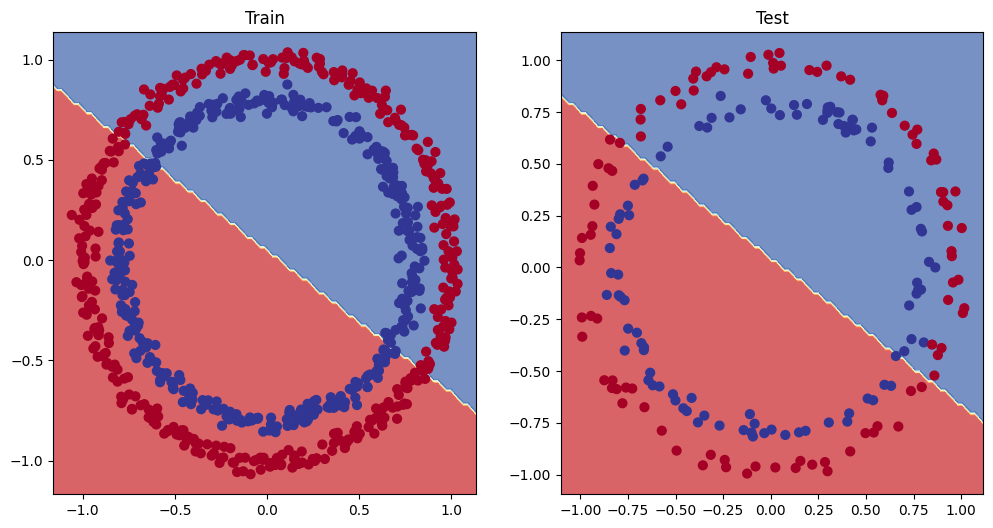

In [71]:
# make predictions
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)